## FINAL PROJECT
Frederik Kallestrup Mastratis (qln174)  
Dongyu Liu (dlf327)  
Shamim Tariq Akram (zmx145)  
Celina Aurora Nguyen (szf345)  

Group 21

## PACKAGES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from cleantext import clean
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn import linear_model, metrics, naive_bayes, svm, neural_network

import psycopg2

## TEXT CLEANER

In [22]:
DATE = '3[01]|[12][0-9]|0?[1-9]'
DATE_SUFFIXES = 'st|th|rd|nd'
DAY = '(mon|tues|thurs|fri|sun)(day)?|wed(nesday)?|sat(urday)?'
YEAR = '([12][0-9])?[0-9]{2}'
MONTHS = 'jan\.?(uary)?|feb\.?(ruary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.?(e)?|jul\.?(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?'

# format: pretty much all digit formats DD/MM/YY etc.
fd1 = '((%s)\s,?)?\d{1,4}[\\/-]\d{1,2}[\\/-]\d{1,4}' % (DAY)
# format: DD-DD MON (YYYY)
fd2 = '((%s)\s,?)?(%s)(%s)?(\s?-\s?(%s))?\s(%s)(\s?,?\s(%s))?' % (DAY, DATE, DATE_SUFFIXES, DATE, MONTHS, YEAR)
# format: MON DD-DD (YYYY)
fd3 = '((%s)\s,?)?(%s)\s(%s)(%s)?(\s?-\s?(%s))?(\s?,?\s(%s))?' % (DAY, MONTHS, DATE, DATE_SUFFIXES, DATE, YEAR)
# format: MON YYYY
fd4 = '(%s)\s(%s)?' % (MONTHS, YEAR)

DATES_REGEX = re.compile(r"(%s)|(%s)|(%s)|(%s)" % (fd1, fd2, fd3, fd4))

def clean_text(txt):
    txt = txt.lower()

    txt = re.sub(r"\s+", " ", txt)
    regex = {" EMAIL " : r"\w+@\w+(\.[a-z]{2})?\.[a-z]{2,3}",
        " URL " : r"([a-z\d]+://)?[a-z]+[a-z\d]*(\.[a-z\d\-\._~]+)+(/[a-z\d\-\._~]*|(\?[a-z\d\-\._~]+=[a-z\d\-\._~]+))*",
        " DATE " : DATES_REGEX,
        " NUM " : r"[+-]?((\d+(,|\.))*\d+)"}

    for k in regex.keys():
      txt = re.sub(regex[k], k, txt)

    txt = re.sub(r"/", "", txt)

    # Extra cleaning with cleantext library
    txt = clean(txt,
      lower=False,
      normalize_whitespace=True,
      no_line_breaks=True,
      strip_lines=True,
      no_numbers=True, replace_with_number= ' NUM ',
      no_urls=True, replace_with_url=' URL ',
      no_emails=True, replace_with_email=' EMAIL ',
      no_punct=True, replace_with_punct=''
    )

    tokens = word_tokenize(txt)
    prepostfix = lambda t: "<"+t+">" if t.isupper() else t
    tokens = list(map(prepostfix, tokens))

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    stemmer = SnowballStemmer(language='english')
    tokens = [stemmer.stem(w) if w[0] != '<' else w for w in tokens]
    
    return tokens

In [5]:
##lemmatize
def tokenize_mood(txt):
  tokens = nltk.sent_tokenize(txt)
  prepostfix = lambda t: "<"+t+">" if t.isupper() else t
  return map(lambda sentence: map(prepostfix, sentence), tokens)

def mood_mapper(mood):
  if mood.startswith('J'):
        return wordnet.ADJ
  elif mood.startswith('V'):
        return wordnet.VERB
  elif mood.startswith('N'):
        return wordnet.NOUN
  elif mood.startswith('R'):
        return wordnet.ADV
  else:          
        return None

def Lemm(tokenss):
  lemmatize = WordNetLemmatizer().lemmatize
  stop_words = set(stopwords.words('english'))
  tss = map(lambda ts: map(lambda t: (t[0], mood_mapper(t[1]))), tokenss)
  lemmatized = []
  for ts in tss:
    for word, mood in ts:
      w = word if mood is None else lemmatize(word, mood)
      if not w in stop_words: 
        lemmatized.append(w)
  return lemmatized

In [6]:
df_test = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", delimiter=",")

df_test = df_test.dropna(subset =["type"])

df_content = df_test["content"]
df_tokens = df_content.apply(clean_text)

df_test["tokens"] = df_tokens
df_cleaned = df_tokens.apply(lambda x: ' '.join(x))
df_test["cleaned_content"] = df_cleaned

df_cleaned.to_csv('testclean.csv')

## Observations

1. **Length by article type (*type_token_relation*):** 
This boxplot gives the distribution of the length of the articles in tokens within article types. Taking into consideration that the supermajority of articles types are undersamples in the data set (<6) (observation 2) this observation does not make it seem likely that there is a useful correlation between length and type.  
2. **URL token frequency by article type (*type_URLfreq_relation*):**
This boxplot gives the distribution of the frequency of the URL token within article type. It shows that many types are undersampled. This motivated us to look at the criteria for the types in the FakeNewsCorpus; aritcle types are mutually exclusive, but their semantics are not. This begs the question how FakeNews corpus decides when multiple types are appropriate - it seems that they have som rank-order for which type takes precedens, though as observation 4 shows this cannot be concluded.  
3. **Distribution of types (*type_distribution*):**
This barplot shows the distribution of types. From it we can conclude that the data(sub)set has an exponential drop-off in how populated each types is. Since we only have about 250 articles this means that the less populated types are very undersampled.
4. **Distribution of types within a domain(*domain_type_relation*)**
Most interestingly this oberservation shows us that each domain only have one type associated with them. This means that we have to be careful about what our model is actually checking; it could be that it is only checking the domain (through inference by the structure of the tokens) and then guesses by the type associated with the domain. It also shows that the datasubset have very few articles associated for each domain (<3).

In [7]:
# Function which returns list of token counts [URL, NUM, DATA, EMAIL, ALL_tokens]
def count_tokens(tokens):
    meta_tokens  = ["<URL>", "<NUM>", "<DATE>", "<EMAIL>"]
    meta_counts = [0, 0, 0, 0]
    for token in tokens:
      if token in meta_tokens:
        i = meta_tokens.index(token)
        meta_counts[i] += 1
    token_count = len(tokens)
    return [token_count] + meta_counts


# Observation 1 - relationship between type and tokencount (length of article)
def type_token_relation(df):
    counts = df["tokens"].apply(count_tokens)
    tokens = counts.apply(lambda xs: xs[0])
    tokens = tokens.rename("token_count")
    df_temp = pd.concat([df["type"], tokens], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["token_count"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 2 - relationship between type and URL frequency
def type_URLfreq_relation(df):
    counts = df["tokens"].apply(count_tokens)
    url_freq = counts.apply(lambda xs: xs[1]/xs[0])
    url_freq = url_freq.rename("url_freq")
    df_temp = pd.concat([df["type"], url_freq], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["url_freq"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 3 - type distribution of dataset
def type_distribution(df):
    df['type'].value_counts().plot.bar()
    return df['type'].value_counts()

# Observation 4 - types of article each domain publishes
def domain_type_relation(df):
    domains = df["domain"].unique()
    types = []
    for domain in domains:
        types.append(df[df["domain"] == domain]["type"].value_counts().to_dict())
    idx = sorted(range(len(types)), key=lambda i: list(types[i].items())[0][1])
    return list(map(lambda i: (domains[i], types[i]), reversed(idx)))

unreliable     181.666667
fake           377.606452
clickbait      163.000000
conspiracy     461.483871
reliable       256.666667
bias           253.833333
hate            32.000000
junksci        219.166667
political      368.260870
unknown       1226.166667
dtype: float64

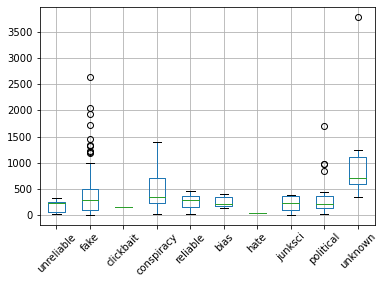

In [8]:
type_token_relation(df_test)

unreliable    0.016894
fake          0.011174
clickbait     0.000000
conspiracy    0.006394
reliable      0.002193
bias          0.012063
hate          0.000000
junksci       0.024873
political     0.006453
unknown       0.003593
dtype: float64

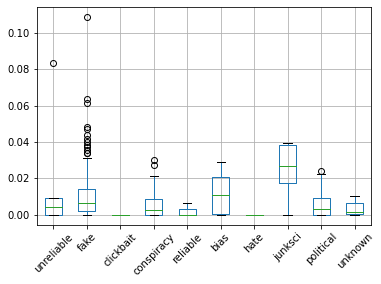

In [9]:
type_URLfreq_relation(df_test)

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

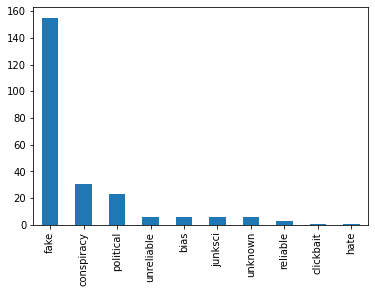

In [10]:
type_distribution(df_test)

In [11]:
domain_type_relation(df_test)

[('beforeitsnews.com', {'fake': 155}),
 ('canadafreepress.com', {'conspiracy': 24}),
 ('washingtonexaminer.com', {'political': 17}),
 ('awarenessact.com', {'conspiracy': 6}),
 ('naturalnews.com', {'junksci': 5}),
 ('strategic-culture.org', {'unknown': 4}),
 ('christianpost.com', {'reliable': 3}),
 ('city-journal.org', {'political': 2}),
 ('vdare.com', {'bias': 2}),
 ('undergroundhealth.com', {'unknown': 2}),
 ('alternet.org', {'political': 2}),
 ('awm.com', {'unreliable': 2}),
 ('breitbart.com', {'political': 1}),
 ('anonhq.com', {'unreliable': 1}),
 ('americanlookout.com', {'bias': 1}),
 ('washingtonsblog.com', {'bias': 1}),
 ('21stcenturywire.com', {'conspiracy': 1}),
 ('unz.com', {'bias': 1}),
 ('nationalreview.com', {'political': 1}),
 ('collectivelyconscious.net', {'junksci': 1}),
 ('breakpoint.org', {'unreliable': 1}),
 ('barenakedislam.com', {'hate': 1}),
 ('charismanews.com', {'bias': 1}),
 ('blackagendareport.com', {'unreliable': 1}),
 ('bipartisanreport.com', {'clickbait': 1}

## TRAINING

In [3]:
conn = psycopg2.connect(dbname="fakenewsdb", user="postgres", password="1234")

In [4]:
# Dataset for model

query_fnc = """
    SELECT id, type, content
    FROM fnc_article
"""

df_fncpull = pd.read_sql(query_fnc, conn)

KeyboardInterrupt: 

In [3]:
df_fncpull = pd.read_csv('200krandFNC.csv')

df_fncpull = df_fncpull[['id', 'content', 'type']]

df_fncpull['type'].value_counts()

KeyboardInterrupt: 

In [7]:
type_real = ['political', 'reliable', 'clickbait']
type_fake = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate']

def type_classifier(type):
    if type in type_real:
        type = 1
    elif type in type_fake:
        type = 0

    return type

In [8]:
df_fncpull = df_fncpull[df_fncpull['type'].isin(type_real + type_fake)]

df_fncpull['type'] = df_fncpull['type'].apply(type_classifier)

df_fncpull['type'].value_counts()

0    81318
1    63527
Name: type, dtype: int64

In [9]:
df_fnccontent = df_fncpull["content"]
df_fnctokens = df_fnccontent.apply(clean_text)

df_fnccleaned = df_fnctokens.apply(lambda x: ' '.join(x))
df_fncpull["content"] = df_fnccleaned

df_fncpull.to_csv('fncpullcleaned200k.csv', index = False)

In [12]:
df_fncpull = pd.read_csv('fncpullcleaned200k.csv')

df_fncpull.shape

(144845, 3)

In [13]:
df_fncpull = df_fncpull.drop_duplicates(subset = 'content')


df_fncpull.shape

(111900, 3)

24129        10
141294       12
143377       13
103304       15
13665        16
          ...  
117471    68161
117284    68609
90780     77033
120589    77853
115097    88844
Name: content, Length: 111900, dtype: int64

In [14]:
X_train, X_rem, y_train, y_rem = train_test_split(df_fncpull['content'], df_fncpull['type'], train_size = 0.7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5)

In [15]:
X_train.to_csv('X_trainFNC.csv', index = False)
y_train.to_csv('y_trainFNC.csv', index = False)
X_test.to_csv('X_testFNC.csv', index = False)
y_test.to_csv('y_testFNC.csv', index = False)
X_valid.to_csv('X_validFNC.csv', index = False)
y_valid.to_csv('y_validFNC.csv', index = False)

In [29]:
X_train.shape



pandas.core.series.Series

In [13]:

vectorizer = TfidfVectorizer(       
    lowercase=False, 
    ngram_range=(1,1), 
    token_pattern=r"(?u)\b\w\w+\b|<DATE>|<NUM>|<EMAIL>|<URL>",
    min_df=3
)

In [20]:
vectorizer.fit(X_train)

len(vectorizer.get_feature_names())

98724

In [21]:
n_train = X_train.shape[0]
n_val = X_valid.shape[0]

X_trainval = np.concatenate((X_train, X_valid))
y_trainval = np.concatenate((y_train, y_valid))

test_fold = -1*np.ones(X_trainval.shape[0])
test_fold[n_train:] = 0
pds = PredefinedSplit(test_fold)

TFIDF_Xtrainval = vectorizer.transform(X_trainval)

TFIDF_Xtrain = vectorizer.transform(X_train)
TFIDF_Xvalid = vectorizer.transform(X_valid)
TFIDF_Xtest = vectorizer.transform(X_test)


### Logistic Regression

In [77]:
# Baseline hyperparameter tuning Log.reg

LR_model = linear_model.LogisticRegression()

LR_param = [
    {'penalty' : ['l1'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['liblinear']},
    {'penalty' : ['l2'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['lbfgs','newton-cg','saga']}
]

LR_gs = GridSearchCV(LR_model, param_grid = LR_param, cv=pds, verbose = 5, n_jobs = -1)

In [78]:
LR_base = LR_model.fit(TFIDF_Xtrain, y_train)

In [79]:
LR_gs.fit(TFIDF_Xtrainval, y_trainval)
LR_bestparam = LR_gs.best_params_
print(LR_bestparam)

Fitting 1 folds for each of 80 candidates, totalling 80 fits
{'C': 4.281332398719396, 'penalty': 'l1', 'solver': 'liblinear'}


In [81]:
LR_tuned = linear_model.LogisticRegression(**LR_bestparam)
LR_tuned.fit(TFIDF_Xtrain, y_train)

LogisticRegression(C=4.281332398719396, penalty='l1', solver='liblinear')

In [82]:
print (f'Base Accuracry: {LR_base.score(TFIDF_Xtest, y_test):.3f}\nTuned Accuracy: {LR_tuned.score(TFIDF_Xtest, y_test):.3f}')

Base Accuracry: 0.846
Tuned Accuracy: 0.851


In [83]:
LRbase_pp = LR_base.predict_proba(TFIDF_Xtest)[::,1]
LRtuned_pp = LR_tuned.predict_proba(TFIDF_Xtest)[::,1]

LRbase_fpr, LRbase_tpr, _ = metrics.roc_curve(y_test, LRbase_pp)
LRtuned_fpr, LRtuned_tpr, _ = metrics.roc_curve(y_test, LRtuned_pp)

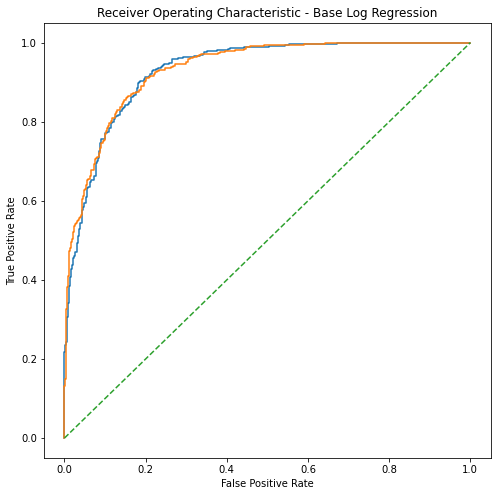

In [84]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Base Log Regression')
plt.plot(LRbase_fpr, LRbase_tpr)
plt.plot(LRtuned_fpr, LRtuned_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Naive Bayes

In [101]:
# Naive Bayes

NB_model = naive_bayes.MultinomialNB()

NB_param = [
    {'alpha' : [0.0, 0.01, 0.05] + np.linspace(0.1, 1, 10).tolist() + [5.0, 10.0, 100.0]}
]

NB_gs = GridSearchCV(NB_model, param_grid = NB_param, cv=pds, verbose = 5, n_jobs = -1)

In [102]:
NB_base = NB_model.fit(TFIDF_Xtrain, y_train)

In [108]:
NB_gs.fit(TFIDF_Xtrainval, y_trainval)
NB_bestparam = NB_gs.best_params_
print(NB_bestparam)

Fitting 1 folds for each of 16 candidates, totalling 16 fits
{'alpha': 0.1}


In [109]:
NB_tuned = naive_bayes.MultinomialNB(**NB_bestparam)
NB_tuned.fit(TFIDF_Xtrain, y_train)

MultinomialNB(alpha=0.1)

In [110]:
print (f'Base Accuracry: {NB_base.score(TFIDF_Xtest, y_test):.3f}\nTuned Accuracy: {NB_tuned.score(TFIDF_Xtest, y_test):.3f}')

Base Accuracry: 0.828
Tuned Accuracy: 0.839


In [92]:
NBbase_pp = NB_base.predict_proba(TFIDF_Xtest)[::,1]
NBtuned_pp = NB_tuned.predict_proba(TFIDF_Xtest)[::,1]

NBbase_fpr, NBbase_tpr, _ = metrics.roc_curve(y_test, NBbase_pp)
NBtuned_fpr, NBtuned_tpr, _ = metrics.roc_curve(y_test, NBtuned_pp)

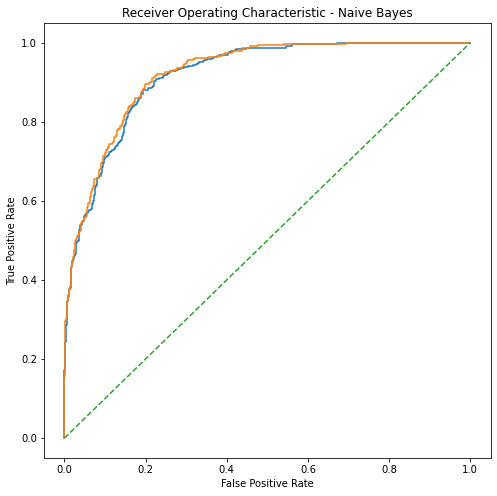

In [93]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(NBbase_fpr, NBbase_tpr)
plt.plot(NBtuned_fpr, NBtuned_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Support Vector Machine

In [95]:
SVM_model = svm.SVC(probability=True)

SVM_param = [
    {'kernel' : ['linear'], 'C' : [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
]

SVM_gs = GridSearchCV(SVM_model, param_grid = SVM_param, cv=pds, verbose = 5, n_jobs = -1)

In [96]:
SVM_base = SVM_model.fit(TFIDF_Xtrain, y_train)

In [97]:
SVM_gs.fit(TFIDF_Xtrainval, y_trainval)
SVM_bestparam = SVM_gs.best_params_
print(SVM_bestparam)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
{'C': 1.0, 'kernel': 'linear'}


In [112]:
SVM_tuned = svm.SVC(probability=True, **SVM_bestparam)
SVM_tuned.fit(TFIDF_Xtrain, y_train)

SVC(kernel='linear', probability=True)

In [111]:
print (f'Base Accuracry: {SVM_base.score(TFIDF_Xtest, y_test):.3f}\nTuned Accuracy: {SVM_tuned.score(TFIDF_Xtest, y_test):.3f}')

NameError: name 'SVM_tuned' is not defined

In [ ]:
SVMbase_pp = SVM_base.predict_proba(TFIDF_Xtest)[::,1]
SVMtuned_pp = SVM_tuned.predict_proba(TFIDF_Xtest)[::,1]

SVMbase_fpr, SVMbase_tpr, _ = metrics.roc_curve(y_test, SVMbase_pp)
SVMtuned_fpr, SVMtuned_tpr, _ = metrics.roc_curve(y_test, SVMtuned_pp)

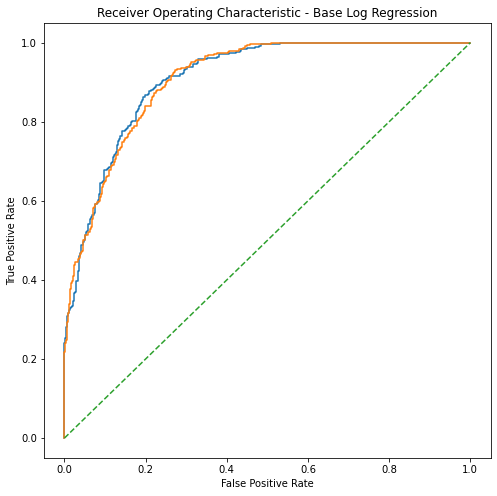

In [ ]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Base Log Regression')
plt.plot(SVMbase_fpr, SVMbase_tpr)
plt.plot(SVMtuned_fpr, SVMtuned_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### FEED FORWARD NEURAL NETWORK

In [1]:
ANN_model = neural_network.MLPClassifier()

ANN_param = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'activation': ['logistic', 'relu'], 
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

ANN_gs = GridSearchCV(ANN_model, param_grid = ANN_param, cv=pds, verbose = 5, n_jobs = -1)

NameError: name 'neural_network' is not defined

In [ ]:
ANN_base= ANN_model.fit(TFIDF_Xtrain, y_train)

In [ ]:
ANN_gs.fit(TFIDF_Xtrainval, y_trainval)
ANN_bestparam = ANN_gs.best_params_
print(ANN_bestparam)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
ANN_tuned = neural_network.MLPClassifier(**ANN_bestparam)
ANN_tuned.fit(TFIDF_Xtrain, y_train)

In [ ]:
print (f'Base Accuracry: {ANN_base.score(TFIDF_Xtest, y_test):.3f}\nTuned Accuracy: {ANN_tuned.score(TFIDF_Xtest, y_test):.3f}')

Accuracry: 0.795


In [ ]:
ANNbase_pp = ANN_base.predict_proba(TFIDF_Xtest)[::,1]
ANNtuned_pp = ANN_tuned.predict_proba(TFIDF_Xtest)[::,1]

ANNbase_fpr, ANNbase_tpr, _ = metrics.roc_curve(y_test, ANNbase_pp)
ANNtuned_fpr, ANNtuned_tpr, _ = metrics.roc_curve(y_test, ANNtuned_pp)

In [ ]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(ANNbase_fpr, ANNbase_tpr)
plt.plot(ANNtuned_fpr, ANNtuned_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
def truth_mapper(value):
    true_set = {'true', 'half-true', 'barely-true', 'mostly-true'}
    false_set = {'false', 'pants-fire'}
    if value in true_set:
        return 1
    elif value in false_set:
        return 0
    else:
        raise ValueError

def map_project_truth(liar_df):
    truths = liar_df[1]
    return truths.apply(truth_mapper)



def get_liar():
    liar_tests = pd.read_csv("LIAR Dataset/test.tsv", sep='\t', header=None)
    liar_trains = pd.read_csv("LIAR Dataset/train.tsv", sep='\t', header=None)
    liar_valid = pd.read_csv("LIAR Dataset/valid.tsv", sep='\t', header=None)
    liar = pd.concat([liar_tests, liar_trains, liar_valid], ignore_index = True)
    return liar[2], map_project_truth(liar)

In [45]:
X_liar, y_liar = get_liar()

X_liar = X_liar.apply(clean_text)
X_liar = X_liar.apply(lambda x: ' '.join(x))

In [46]:
X_liar.to_csv('X_liar.csv', index = False)
y_liar.to_csv('y_liar.csv', index = False)

In [23]:
wikinews = pd.read_csv('wikinews.csv')

wikinews = wikinews['content']
wikinews = wikinews.apply(clean_text)
wikinews = wikinews.apply(lambda x: ' '.join(x))
wikinews = wikinews.dropna()

In [26]:
wikinews

0       free trade zone antalya turkey <NUM> women wor...
1       sunday <DATE> polic offic luiz pereira da silv...
2       novak stori spark contoversi written <DATE> st...
3       isra prime minist ehud olmert palestinian pres...
4       palestinian author chairman mahmoud abba fire ...
                              ...                        
3080    roy bennett key zimbabwean opposit leader die ...
3081    zimbabwean presid robert mugab opposit leader ...
3082    talk zimbabwean presid robert mugab prime mini...
3083    presid vladimir voronin moldova today sign dec...
3084    fortyf percent american adult survey zogbi pol...
Name: content, Length: 3085, dtype: object

In [31]:
wikinews = wikinews.replace(r'^s*$', np.NaN, regex = True)
wikinews = wikinews.dropna()
wikinews

0       free trade zone antalya turkey <NUM> women wor...
1       sunday <DATE> polic offic luiz pereira da silv...
2       novak stori spark contoversi written <DATE> st...
3       isra prime minist ehud olmert palestinian pres...
4       palestinian author chairman mahmoud abba fire ...
                              ...                        
3080    roy bennett key zimbabwean opposit leader die ...
3081    zimbabwean presid robert mugab opposit leader ...
3082    talk zimbabwean presid robert mugab prime mini...
3083    presid vladimir voronin moldova today sign dec...
3084    fortyf percent american adult survey zogbi pol...
Name: content, Length: 3085, dtype: object

In [25]:
wikinews.to_csv('X_wikinews.csv', index = False)

y_wikinews = pd.Series(np.ones(wikinews.shape[0], dtype = int))

y_wikinews.to_csv('y_wikinews.csv', index = False)